## Classifying ecoli using Decision Trees and Support Vector Machines
**Author: Prathyusha Sangam**

### About the data

The data is obtained from UCI machine learning repository. It provides information about Cellular Localization Sites of Proteins on some E. Coli bacteria.

Attributes:
1. Sequence Name: Accession number for the SWISS-PROT database (name)
2. mcg: McGeoch's method for signal sequence recognition.
3. gvh: von Heijne's method for signal sequence recognition.
4. lip: von Heijne's Signal Peptidase II consensus sequence score. Binary attribute.
5. chg: Presence of charge on N-terminus of predicted lipoproteins. Binary attribute.
6. aac: score of discriminant analysis of the amino acid content of outer membrane and periplasmic proteins.
7. alm1: score of the ALOM membrane spanning region prediction program.
8. alm2: score of ALOM program after excluding putative cleavable signal regions from the sequence.
9. target: Localization site of protein.(non-numeric)


### Project Objective
1. To classify protein localization sites (8 target values)
2. Technique used: Decision Trees and Support Vector Machines


### Document Outline
* [Step 1: Set up imports and load data](#Step-1:-Set-up-imports-and-load-data)
* [Step 2: Understand the data](#Step-2:-Understand-the-data)
    * [Findings of step 2 and relevant decisions](#Findings-of-step-2-and-relevant-decisions:)
* [Step 3: Data manipulation: converting (encoding) labels to numeric values](#Step-3:-Data-manipulation)
* [Step 4: Stratified Train-Test Splits](#Step-4:-Stratified-Train-Test-Splits)
* [Step 5: Building a classifier using Decision Trees](#Step-5:-Building-Classifier-using-Decision-Trees)
    * [Evaluating Decision Tree performance](#Evaluating-Decision-Tree-performance)
* [Step 6: Building a classifier using Support Vector Machines](#Step-6:-Building-classifier-using-Support-Vector-Machines)
    * [Evaluating SVM performance](#Evaluating-the-performance-of-SVM)

### Step 1: Set up imports and load data

In [305]:
# allowing multiple/scrollable outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#ML
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#data wrangling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [306]:
# data loading

#loading .data file
ecoli_data = pd.read_csv("Datasets/ecoli.data", sep="\s+", header=None)

# adding column names
ecoli_data.columns = ["name", "mcg", "gvh", "lip","chg","aac","alm1","alm2","target"]

ecoli_data.head()

,name,mcg,gvh,lip,chg,aac,alm1,alm2,target
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


**[Back to top](#Document-Outline)**
### Step 2: Understand the data

In [307]:
# descriptive stats (7 numeric attributes)
ecoli_data.describe()

# Are there any null values (missing data) ?
print("null values:", ecoli_data.isnull().sum().sum())

,mcg,gvh,lip,chg,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


null values: 0


cp     143
im      77
pp      52
imU     35
om      20
omL      5
imL      2
imS      2
Name: target, dtype: int64

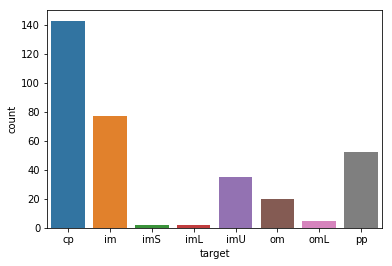

In [308]:
# Class distributions
sns.countplot('target',data= ecoli_data)
ecoli_data['target'].value_counts()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f1d4630>,
      dtype=object)

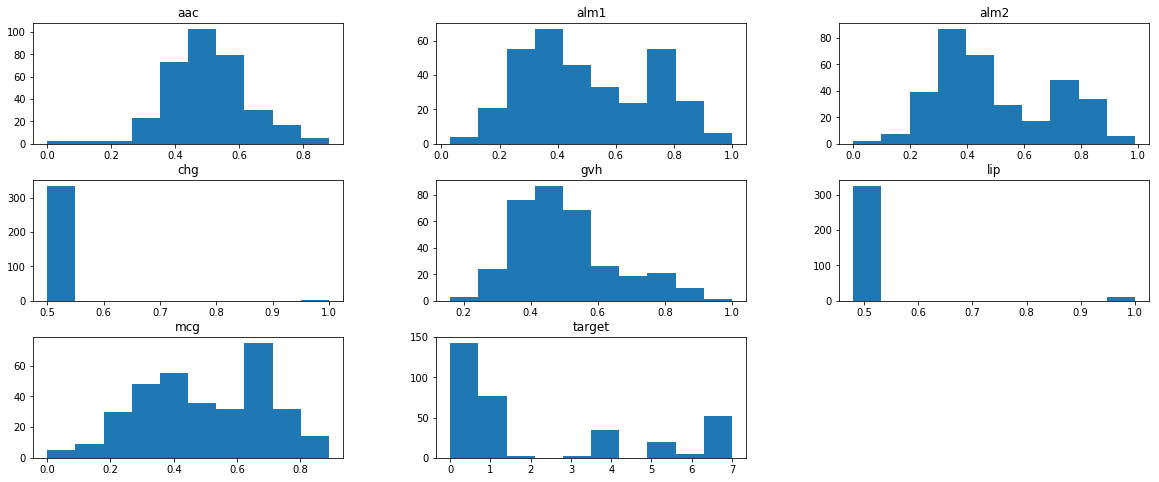

In [321]:
#histograms of the numeric attributes {mcg, gvh, lip, chg, aac, alm1, alm2}

ecoli_data.hist(layout = (3,3),figsize=(20,8), grid = False)

**[Back to top](#Document-Outline)**
### Findings of step 2 and relevant decisions:
1\. There are 336 rows and 9 columns including the target. The target represents one of 8 possible localization sites (categorical). The data includes 7 numeric features (columns).

2\. The feature "name" is a unique identifier of the database it originally extracted from, and hence, (due to lack of relevance) it can be ignored for our ML training task.

3\. The values of numeric attributes, {mcg, gvh, lip, chg, aac, alm1, alm2}, according to data descrption are various "scores". They mostly lie between 0-1. From the histograms we see their distributions are not normal. lip, chg are binary. lip takes the values 0.48 or 1, chg takes values 0.5 or 1. Since we are unsure of the units and data is not normal, it might be a good idea to scale the features using Standard Scaler.

4\. The class distribution of targets is uneven, with largest number of "cp" class with 143 tuples and least "imL","imS" classes with 2 tuples each. Due to this variation, it is better to perform stratified sampling for train-test splits, to make sure we don't miss some of the labels during training.

** [Back to top](#outline) **
### Step 3: Data manipulation
We need to change categorical (object type) targets to numeric values

In [310]:
#changing categorical target to numerical

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(ecoli_data['target'])
ecoli_data['target'] = le.transform(ecoli_data['target'])

#How did the label encoder map the targets?
targets = ['cp', 'im', 'pp', 'imU', 'om', 'omL','imL','imS']
map1 = le.transform(targets)

mapping = pd.DataFrame(map1,targets)
mapping


LabelEncoder()

,0
cp,0
im,1
pp,7
imU,4
om,5
omL,6
imL,2
imS,3


** [Back to top](#outline) **
### Step 4: Stratified Train-Test Splits
Before performing the classification task, we will make Train Test splits in 80:20 ratio (industry recommended).
Since there are huge variations in number of samples of each category, we can perform stratified sampling.

#### Naming convention of the train-test splits:
* X_train: Training data frame containing features - without labels
* y_train: Data labels for training
* X_test: testing data frame containing features - without labels
* y_test: Original data labels of test data

In [311]:
#Separating X and y from original dataframe

X = ecoli_data.iloc[:,1:8]
y = ecoli_data.iloc[:,8]

X.head()
y.head()

,mcg,gvh,lip,chg,aac,alm1,alm2
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [312]:
#test train splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state = 42)

#verifying the splits

print("Checking the ratio of labels in test and train splits: imL,imS are not chosen for testing")

y_train.value_counts() / len(y_train)
y_test.value_counts() / len(y_test)


Checking the ratio of labels in test and train splits: imL,imS are not chosen for testing


0    0.425373
1    0.227612
7    0.152985
4    0.104478
5    0.059701
6    0.014925
3    0.007463
2    0.007463
Name: target, dtype: float64

0    0.426471
1    0.235294
7    0.161765
4    0.102941
5    0.058824
6    0.014706
Name: target, dtype: float64

In [313]:
# Feature scaling using Standard scaler for "X"

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.astype(np.float64))
X_test = scaler.fit_transform(X_test.astype(np.float64))

** [Back to top](#outline) **
### Step 5: Building Classifier using Decision Trees
Hyperparameter consideration: max_depth =8

In [314]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score


dtree = DecisionTreeClassifier(random_state=42,max_depth=8)
dtree.fit(X_train, y_train)

# Cross Val Score - Training
np.random.seed(42)
cross_val_score(dtree, X_train, y_train, cv=3, scoring="accuracy",n_jobs=1)


# Training 
dtree_train_pred = dtree.predict(X_train)
dtree_train_score = dtree.score(X_train, y_train)


# Testing
dtree_test_pred = dtree.predict(X_test)
dtree_test_score = dtree.score(X_test, y_test)


# Model Evaluation

dtree_model = pd.DataFrame({
    'Performance Measures': ['Training Accuracy of Decision tree', 'Testing Accuracy of Decision tree'],
    'Scores': [dtree_train_score,dtree_test_score]})

dtree_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

array([0.66666667, 0.76404494, 0.80232558])

,Performance Measures,Scores
0,Training Accuracy of Decision tree,0.973881
1,Testing Accuracy of Decision tree,0.838235


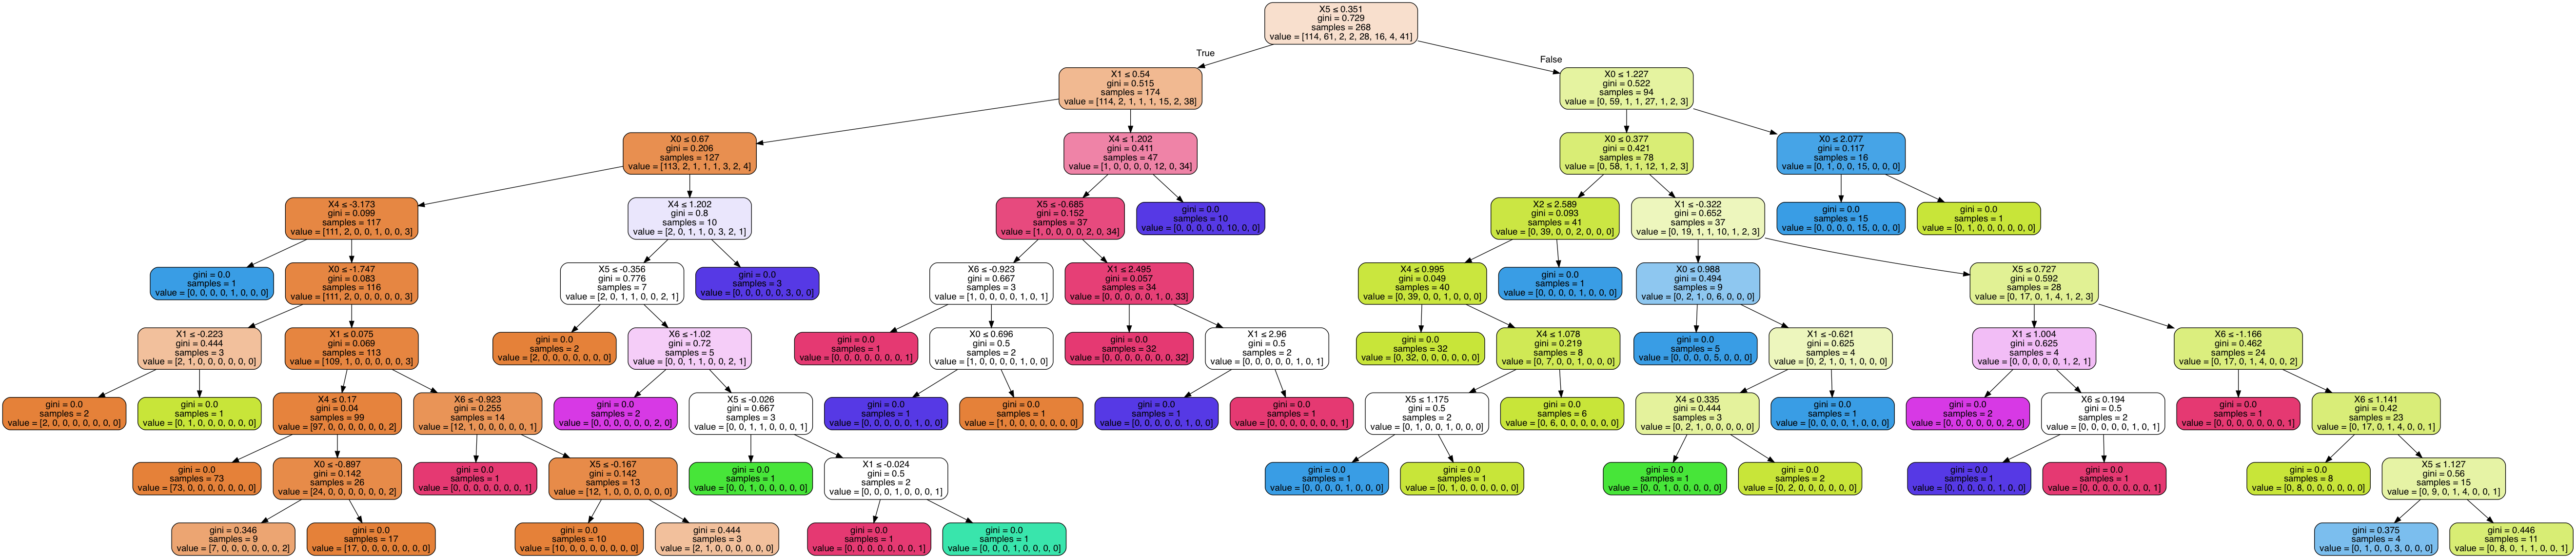

**DOUBLE CLICK ON IMAGE TO ZOOM IN AND SCOLL TO VIEW**


In [315]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
print("**DOUBLE CLICK ON IMAGE TO ZOOM IN AND SCOLL TO VIEW**")

In [316]:
print("CLASSIFICATION REPORT DURING TRAINING: \n",classification_report(y_train, dtree_train_pred))

CLASSIFICATION REPORT DURING TRAINING: 
              precision    recall  f1-score   support

          0       0.97      1.00      0.99       114
          1       0.95      0.97      0.96        61
          2       1.00      1.00      1.00         2
          3       1.00      0.50      0.67         2
          4       0.96      0.96      0.96        28
          5       1.00      1.00      1.00        16
          6       1.00      1.00      1.00         4
          7       1.00      0.93      0.96        41

avg / total       0.97      0.97      0.97       268



In [317]:
print("CLASSIFICATION REPORT DURING TESTING: \n",classification_report(y_test, dtree_test_pred))

CLASSIFICATION REPORT DURING TESTING: 
              precision    recall  f1-score   support

          0       0.97      1.00      0.98        29
          1       0.82      0.56      0.67        16
          3       0.00      0.00      0.00         0
          4       0.50      0.86      0.63         7
          5       1.00      1.00      1.00         4
          6       0.00      0.00      0.00         1
          7       0.90      0.82      0.86        11

avg / total       0.86      0.84      0.84        68



** [Back to top](#outline) **
### Evaluating Decision Tree performance
1\. We chose hyperparameter max_depth=8 because trials with higher depth led to overfit during training (100% accuracy) and poor performance in test, whereas lower depth led to too much constrainment, causing accuracy during test to be lower.

2\. Cross validation with cv=3 gave accuracies ranging from 67% to 80% during training phase. 

3\. However, overall accuracy (1 fold) of the classifier during training was observed to be 97.4% and during testing phase accuracy was 83.82%, which is decent given the skewed data.

4\. As seen from the classification report generated, the performance of the classifier could be improved by obtaining more data of the low cardinality labels such as imS(label 3), imL(label 2) , inorder to make better decisions.

** [Back to top](#outline) **
### Step 6: Building classifier using Support Vector Machines

In [318]:
# Support Vector Machines

svc = SVC(random_state=42)
svc.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Cross Val Score - Training
cross_val_score(svc, X_train, y_train, cv=3, scoring="accuracy",n_jobs=1)

# Training 
svc_train_pred = svc.predict(X_train)
svc_train_score = svc.score(X_train, y_train)


# Testing
svc_test_pred = svc.predict(X_test)
svc_test_score = svc.score(X_test, y_test)

# Model Evaluation

svc_model = pd.DataFrame({
    'Performance Measures': ['Training Accuracy of SVC', 'Testing Accuracy of SVC'],
    'Scores': [svc_train_score,svc_test_score]})

svc_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

array([0.8172043 , 0.88764045, 0.84883721])

,Performance Measures,Scores
0,Training Accuracy of SVC,0.888060
1,Testing Accuracy of SVC,0.897059


In [319]:
print("CLASSIFICATION REPORT DURING TRAINING: \n",classification_report(y_train, svc_train_pred))

CLASSIFICATION REPORT DURING TRAINING: 
              precision    recall  f1-score   support

          0       0.95      0.98      0.97       114
          1       0.81      0.89      0.84        61
          2       1.00      0.50      0.67         2
          3       0.00      0.00      0.00         2
          4       0.78      0.64      0.71        28
          5       0.93      0.88      0.90        16
          6       1.00      1.00      1.00         4
          7       0.88      0.85      0.86        41

avg / total       0.88      0.89      0.88       268



In [320]:
print("CLASSIFICATION REPORT DURING TRAINING: \n",classification_report(y_test, svc_test_pred))

CLASSIFICATION REPORT DURING TRAINING: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        29
          1       0.80      0.75      0.77        16
          4       0.56      0.71      0.63         7
          5       1.00      1.00      1.00         4
          6       0.00      0.00      0.00         1
          7       1.00      1.00      1.00        11

avg / total       0.89      0.90      0.89        68



** [Back to top](#outline) **
### Evaluating the performance of SVM
1\. The SVM used here  has provided consistant results during cross validation. The accuracy obtained during training is 88.8% and during testing, there's a slight improvement 89.7%, however they are very close, indicating there was no underfit/overfit situation.

2\. From the Classification Report we notice why the accuracy/precision/recall scores are better on test. The reason is that the test set din't have any samples of imL and imS labels (very low frequency labels).

3\. The overall performance of the classifier can be improved with better quality data, so is the case with DT. SVM looks more promising for classification, given that there is a high chance of a DT to overfit if hyperparameters are not carefully tuned.

**REFERENCES:**

* Textbook: Hands-On Machine Learning with Scikit-Learn and TensorFlow
* Article: https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
* Python / Scikit Learn documentation
